In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
from glob import glob
import sys
from sklearn.model_selection import train_test_split # train , test 분리에 사용.

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
from tqdm import tqdm
from datetime import datetime

# 데이터 전처리

```

TurbID - 발전기 ID

Day - 날짜

Tmstamp - 시간

Wspd - 풍속

Wdir - 터빈이 바라보는 각도와 실제 바람 방향 각도 차이

Etmp - 외부 온도

Itmp - 터빈 내부 온도

Ndir - 터빈이 바라보는 방향 각도

Pab - 터빈 당 3개의 날이 있으며 각각의 각도가 다름

Prtv - 무효전력 : 에너지원을 필요로 하지 않는 전력

Patv - 유효전력 : 실제로 터빈을 돌리는 일을 하는 전력

````


베이스 라인 제공 전처리 방법

In [3]:
train_data = pd.read_csv("data/train_data.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

In [4]:
# train_data의 결측값 확인
train_data.isnull().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       45587
Wdir       45587
Etmp       45587
Itmp       45587
Ndir       45587
Pab1       45587
Pab2       45587
Pab3       45587
Prtv       45587
Patv       45587
dtype: int64

In [5]:
# method : 결측값을 변경할 방식입니다. bfill로 할경우 결측값을 바로 아래 값과 동일하게 변경합니다.
# 결측값 처리
train_data = train_data.fillna(method = 'ffill').fillna(method = 'bfill')

print(train_data.isnull().sum())

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
dtype: int64


In [6]:
train_data[(train_data["TurbID"]==1)&(train_data["Day"]==1)]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1,1,23:10,9.95,0.49,28.71,42.53,-9.44,1.02,1.02,1.02,-0.29,1330.24
140,1,1,23:20,12.20,0.70,28.59,42.56,-8.17,1.08,1.08,1.08,-0.23,1550.74
141,1,1,23:30,12.66,1.09,28.54,42.23,-8.17,1.08,1.08,1.08,-0.21,1549.66
142,1,1,23:40,12.58,1.70,28.48,42.09,-8.17,1.08,1.08,1.08,-0.20,1549.64


# 데이터셋

In [7]:
# 한 Turb당 194 line
# label은 2일.로 나눠야함.

def make_train_data(data):
    train_x, train_y = [], []
    for i in tqdm(sorted(pd.unique(data["TurbID"]))):
        tmp_data = data[data["TurbID"] == i]
        for j in range(1, 195): # 1~195 (1~194까지?)
            
            # train data ==> 5일 단위
            # label data ==> 2일 단위
            #day_list = [x for x in range(j, j+ 5)]
            day_list = [x for x in range(j, j+5)]
            label_day_list = [y for y in range(j+5, j + 7)]
            
            train_tmp = tmp_data[tmp_data["Day"].isin(day_list)]
            label_tmp = tmp_data[tmp_data["Day"].isin(label_day_list)]["Wspd"]
            
            # feature 선택 및 제거
            #train_tmp = train_tmp.drop(["TurbID", "Day","Patv","Etmp","Ndir"], axis = 1)
            train_tmp = train_tmp.drop(["TurbID","Patv","Day","Pab2","Pab3","Etmp","Ndir"], axis = 1)
            
            train_x.append(np.array(train_tmp))
            train_y.append(np.array(label_tmp))
            
    return train_x, train_y



In [8]:
train_origin = train_data.copy()

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
nor = MinMaxScaler()# 

train_data[["Wspd","Wdir","Itmp","Pab1","Prtv"]] = nor.fit_transform(train_data[["Wspd","Wdir","Itmp","Pab1","Prtv"]])

#["TurbID", "Day","Patv","Etmp","Ndir"]

In [10]:
nor.scale_

array([0.03803728, 0.00018877, 0.00167398, 0.00909256, 0.00090075])

In [11]:
#실험
nor.min_=nor.min_[0]
nor.scale_=nor.scale_[0]

In [12]:
nor.inverse_transform(train_data[["Wspd"]])

array([[6.17],
       [6.17],
       [6.27],
       ...,
       [4.23],
       [4.36],
       [4.79]])

In [13]:
tms_list = list(pd.unique(train_data["Tmstamp"]))
#train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : tms_list.index(x) )
#train_data["Tmstamp"] = train_data["Tmstamp"]//6
hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]
train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


X_data, Y_data = make_train_data(train_data)

100%|████████████████████████████████████████████████████████████████████████████████| 134/134 [00:23<00:00,  5.66it/s]


In [13]:
from datetime import datetime
def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)
#출처: https://today-1.tistory.com/55 [Better Than,:티스토리]

ERROR! Session/line number was not unique in

In [14]:
# time stamp label encoding
tms_list = list(pd.unique(train_data["Tmstamp"]))
hour_list = [datetime.strptime(t,"%H:%M").hour for t in tms_list]

train_data["Tmstamp"] = train_data["Tmstamp"].apply(lambda x : hour_list[tms_list.index(x)] )


# Fourier Features
train_data['sin_24_1'] = np.sin(2 * np.pi * train_data['Tmstamp']/23.0)
train_data['cos_24_1'] = np.cos(2 * np.pi * train_data['Tmstamp']/23.0)
fourier_features(train_data['Tmstamp'], 24, 1)

train_data.drop(['Tmstamp'],axis=1,inplace=True)

X_data, Y_data = make_train_data(train_data)
#valid_x, valid_y = make_valid_data(train_data)


 database. History logging moved to new session 1439


TypeError: strptime() argument 1 must be str, not numpy.int64

In [15]:
np.array(X_data)

array([[[ 2.34689996e-01,  5.71311263e-01,  5.27252335e-01, ...,
          5.62728567e-01,  0.00000000e+00,  1.00000000e+00],
        [ 2.34689996e-01,  5.71311263e-01,  5.27252335e-01, ...,
          5.62728567e-01,  0.00000000e+00,  1.00000000e+00],
        [ 2.38493724e-01,  5.71652940e-01,  5.26967759e-01, ...,
          5.62737574e-01,  0.00000000e+00,  1.00000000e+00],
        ...,
        [ 2.25941423e-01,  5.71970076e-01,  5.14597074e-01, ...,
          5.62719559e-01, -2.44929360e-16,  1.00000000e+00],
        [ 2.08063903e-01,  5.71847374e-01,  5.14044662e-01, ...,
          5.62728567e-01, -2.44929360e-16,  1.00000000e+00],
        [ 1.95511601e-01,  5.71971964e-01,  5.13006796e-01, ...,
          5.62719559e-01, -2.44929360e-16,  1.00000000e+00]],

       [[ 4.04716622e-01,  5.71764315e-01,  5.27871706e-01, ...,
          5.62710551e-01,  0.00000000e+00,  1.00000000e+00],
        [ 2.66260936e-01,  5.72223030e-01,  5.27670829e-01, ...,
          5.62809634e-01,  0.00000000e

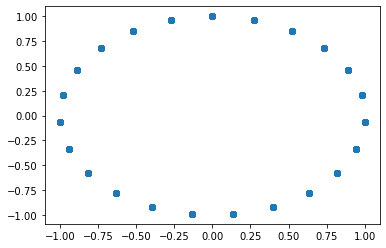

In [14]:
plt.scatter(train_data['sin_24_1'],train_data['cos_24_1'])

In [29]:
len(X_data)

25996

In [16]:
X_data[0].shape[0]

720

In [14]:
X_data  = np.array(X_data).reshape(-1, X_data[0].shape[0], X_data[0].shape[1])
#train_x = np.array(X_data)
Y_data = np.array(Y_data)

In [15]:
#train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#valid_x = np.array(valid_x)
#valid_y = np.array(valid_y)

from sktime.forecasting.all import temporal_train_test_split

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\sktime\utils\validation\_dependencies.py:113: UserWarning: No module named 'prophet'. 'prophet' is a soft dependency and not included in the sktime installation. Please run: `pip install prophet` to install the prophet package. To install all soft dependencies, run: `pip install sktime[all_extras]`
  warnings.warn(msg)


In [16]:
train_y, valid_y, train_x, valid_x = temporal_train_test_split(X=X_data,y=Y_data, test_size=0.1 )
# 0.1 validation :117~121 , ...순서가 잘못됨.
# 0.05 validation :

In [17]:
train_y.shape

(23396, 288)

In [18]:
np.array(train_y).shape

(23396, 288)

In [19]:
train_x  = np.array(train_x).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
train_y= np.array(train_y)
print(train_x.shape, train_y.shape)

(23396, 720, 6) (23396, 288)


In [20]:
valid_x  = np.array(valid_x).reshape(-1, valid_x[0].shape[0], valid_x[0].shape[1])
valid_y = np.array(valid_y)
print(valid_x.shape, valid_y.shape)

(2600, 720, 6) (2600, 288)


In [21]:
pd.DataFrame(valid_x[0])

,0,1,2,3,4,5,6
0,117.0,0.0,0.115253,0.573110,0.513342,0.091017,0.559711
1,117.0,0.0,0.114873,0.574358,0.513743,0.253682,0.555505
2,117.0,0.0,0.076835,0.571840,0.514764,0.091017,0.558576
3,117.0,0.0,0.048307,0.573448,0.513124,0.091017,0.562684
4,117.0,0.0,0.053252,0.574198,0.512572,0.733406,0.562675
...,...,...,...,...,...,...,...
715,121.0,23.0,0.041080,0.567989,0.499130,0.854519,0.562684
716,121.0,23.0,0.054774,0.567540,0.499029,0.854519,0.562684
717,121.0,23.0,0.052111,0.565771,0.498778,0.854519,0.562684
718,121.0,23.0,0.042221,0.565369,0.498426,0.854519,0.562684


input dimension은 (Batch, Time_step, Feature dimension) 순이다. (batch_first=True)

output이 288인 이유는 2일이라서

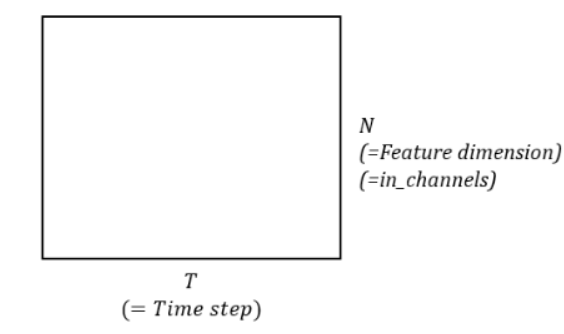

# 데이터 로더

In [21]:
EPOCHS = 30
BATCH_SIZE = 128
lr = 1e-3

In [22]:
from torch.utils.data import Dataset, DataLoader

class TimeDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        
        return torch.Tensor(self.X[index]) # 테스트셋 용
    


In [23]:
train_dataset = TimeDataset(train_x, train_y)
valid_dataset = TimeDataset(valid_x, valid_y)


train_loader = DataLoader(train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(valid_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=True)



# 데이터 확인

In [24]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0].shape)


X_train :  torch.Size([128, 720, 6]) type: torch.FloatTensor
Y_train :  torch.Size([128, 288]) type: torch.FloatTensor
torch.Size([288])


In [25]:
#valiation set 확인
for (X_valid,Y_valid) in valid_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(Y_valid[0].shape)

X_valid :  torch.Size([128, 720, 6]) type: torch.FloatTensor
Y_valid :  torch.Size([128, 288]) type: torch.FloatTensor
torch.Size([288])


# 모델


### input 설명

- input_size: input의 feature dimension을 넣어주어야 한다. time step이 아니라 feature dimension!
- hidden_size: 내부에서 어떤 feature dimension으로 바꿔주고 싶은지를 넣어주면 된다.
- num_layers: lstm layer를 얼마나 쌓을지
- bias: bias term을 둘 것인가 (Default: True)
- batch_first: batch가 0번 dimension으로 오게 하려면 이거 설정! 난 이거 설정 가정하고 설명했다. (Default: False)
- dropout: 가지치기 얼마나 할지, generalization 잘안되면 이걸 조정하면 된다.
bidirectional: 양방향으로 할지 말지 (bidirectional 하면 [forward, backword] 로 feature dimension 2배 됨)



참고.

https://sanghyu.tistory.com/52

### output 설명

- outputs는 (output, (hidden or hidden stat,cell stat)) 의 tuple 형태로 나오므로 주의해서 써야한다. (LSTM만 cell state있음)
- output: output dimension은 (batch, time_step, hidden dimension) 순이다. 양방향일 경우 hidden_size*2
- hidden state: 모든 layer의 hidden state를 담고있다.
- cell state: 모든 layer의 cell state를 담고있다.

In [252]:
lstm = nn.LSTM(input_size=12, hidden_size=256, batch_first=True, bidirectional=False)

lstm(X_valid)[0].size()

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 8

In [253]:
lstm(X_valid)[0][-1].size()

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 8

In [254]:
lstm(X_valid)[1][0]

RuntimeError: input.size(-1) must be equal to input_size. Expected 12, got 8

In [29]:
lstm(X_valid)[0][:,-2,:].size()

torch.Size([128, 256])

In [26]:
lstm_hidden_size=512

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()
        self.lstm = nn.GRU(input_size=6, hidden_size=lstm_hidden_size, batch_first=True,
                           bidirectional=False)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size,512),# 사이즈는 hidden size에 따라 결정.
            nn.ReLU(),
            nn.Linear(512,288), #결과 288개 예측.
            nn.ReLU(),  
        )
        
    def forward(self, x):
        output, _ = self.lstm(x)
        output = self.classifier(output[:,-2,:]) # -1은 hidden state의 마지막 time step값을 가져온 것.
        return output

In [27]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    train_loss = 0
    train_mae_loss = 0
    for batch_idx,(X, Y) in enumerate(train_loader):
        X = X.to(DEVICE)
        Y = Y.to(DEVICE)

        optimizer.zero_grad()#데이터들 장비에 할당
        output = model(X) # model로 output을 계산
        loss = criterion(output, Y)        
        train_loss += loss.item()
        
        with torch.no_grad():
            mae = metric(output, Y)
            train_mae_loss+=mae.item()
        loss.backward()
        optimizer.step()
    
    #train_loss/=len(train_loader.dataset)
    #train_mae_loss/=len(train_loader.dataset)
    
    return train_loss,train_mae_loss
    


In [28]:
#8. 학습
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    valid_mae = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for X, Y in valid_loader:
            X = X.to(DEVICE)
            Y = Y.to(DEVICE)
            output = model(X) # model로 output을 계산
            
            loss = criterion(output, Y)
            valid_loss += loss.item()
            mae = metric(output, Y)
            valid_mae+=mae.item()
    #valid_loss/=len(valid_loader.dataset)
    #valid_mae/=len(valid_loader.dataset)
    return valid_loss, valid_mae


In [29]:
#학습 진행 코드


check_path = './checkpoint/checkpoint_baseline.pt'
print(check_path)
model = BaseModel().to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
metric = nn.L1Loss().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(),lr=lr)

best_valid_mae = 999999
best_valid_loss = 9999999999



for Epoch in range(1,EPOCHS+1):
    train_loss,train_mae = train(model,train_loader,optimizer,log_interval=31)
    valid_loss,valid_mae = evaluate(model, valid_loader)
    
    
    print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train MAE:{:.4f}  | \tValid Loss:{:.4f} \tValid MAE: {:.4f}\n".
                  format(Epoch, train_loss, train_mae,
                         valid_loss, valid_mae ))
    if best_valid_loss > valid_loss:
        print("-- SAVE Checkpoint --")
        print("Valid loss : {:.4f} -> {:.4f} \n".format(best_valid_loss,valid_loss ))
        torch.save(model.state_dict(), check_path, _use_new_zipfile_serialization=False)
        best_valid_mae = valid_mae
        best_valid_loss =valid_loss
        
    
    

./checkpoint/checkpoint_baseline.pt


C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "



[EPOCH:1]	 Train Loss:4.6761	 Train MAE:22.6708  | 	Valid Loss:0.4364 	Valid MAE: 2.2988

-- SAVE Checkpoint --
Valid loss : 9999999999.0000 -> 0.4364 


[EPOCH:2]	 Train Loss:4.2174	 Train MAE:21.2451  | 	Valid Loss:0.4344 	Valid MAE: 2.2932

-- SAVE Checkpoint --
Valid loss : 0.4364 -> 0.4344 


[EPOCH:3]	 Train Loss:3.8919	 Train MAE:20.3757  | 	Valid Loss:0.3577 	Valid MAE: 2.0677

-- SAVE Checkpoint --
Valid loss : 0.4344 -> 0.3577 


[EPOCH:4]	 Train Loss:2.8416	 Train MAE:17.3096  | 	Valid Loss:0.2419 	Valid MAE: 1.7101

-- SAVE Checkpoint --
Valid loss : 0.3577 -> 0.2419 


[EPOCH:5]	 Train Loss:1.6626	 Train MAE:13.0079  | 	Valid Loss:0.1286 	Valid MAE: 1.2104

-- SAVE Checkpoint --
Valid loss : 0.2419 -> 0.1286 


[EPOCH:6]	 Train Loss:0.8730	 Train MAE:9.3136  | 	Valid Loss:0.0804 	Valid MAE: 0.9709

-- SAVE Checkpoint --
Valid loss : 0.1286 -> 0.0804 


[EPOCH:7]	 Train Loss:0.5300	 Train MAE:7.2184  | 	Valid Loss:0.0588 	Valid MAE: 0.8158

-- SAVE Checkpoint --
Valid loss

In [34]:
ddddd

NameError: name 'ddddd' is not defined

# validation 확인

In [259]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.0255 / Valid MAE : 0.5174 



In [30]:
print("Valid loss : {:.4f} / Valid MAE : {:.4f} \n".format(best_valid_loss,best_valid_mae))

Valid loss : 0.0268 / Valid MAE : 0.5291 



# TEST

In [44]:

# 이전 5일치 가져오기.
test_data_list = [x for x in range(196, 201)]

test_data = train_data[train_data["Day"].isin(test_data_list)]
test_data = test_data[test_data['TurbID']==21]

test_data = test_data.drop(["TurbID", "Day","Patv","Pab2","Pab3","Etmp","Ndir"], axis = 1)

test_data = np.array(test_data).reshape(-1, train_x[0].shape[0], train_x[0].shape[1])
#train set 처럼 batch,720,11로 고치기


In [45]:
test_data.shape

(1, 720, 6)

In [46]:
test_dataset = TimeDataset(test_data, None)

test_loader = DataLoader(test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle=False)




In [47]:
def predict(model, test_loader):
    model.eval()
    preds = []
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(DEVICE)
            
            pred = model(X)
            preds += pred.cpu().tolist()
    
    return np.array(preds)

In [48]:
model = BaseModel().to(DEVICE)
best_checkpoint = torch.load('./checkpoint/checkpoint_baseline.pt')
model.load_state_dict(best_checkpoint)
model.eval()

C:\Users\USER\anaconda3\envs\local_torch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


BaseModel(
  (lstm): GRU(6, 512, batch_first=True, dropout=0.2, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=288, bias=True)
    (3): ReLU()
  )
)

In [49]:
preds = predict(model, test_loader)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 50.02it/s]


In [50]:
nor.scale_

0.038037276531000384

In [51]:
preds = nor.inverse_transform(preds)
preds = preds.reshape(-1)

In [52]:
sample_submission = pd.read_csv("data/sample_submission.csv")

In [53]:
for i in range(1,135):
    sample_submission.loc[sample_submission["TurbID"]==i,"Wspd"] = preds

In [54]:

sample_submission.to_csv("./submit.csv", index = False)

In [55]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,201,00:00,3.179828,0,0,0,0,0,0,0,0,9999
1,1,1,201,00:10,2.961957,0,0,0,0,0,0,0,0,9999
2,2,1,201,00:20,2.789909,0,0,0,0,0,0,0,0,9999
3,3,1,201,00:30,2.657440,0,0,0,0,0,0,0,0,9999
4,4,1,201,00:40,2.642220,0,0,0,0,0,0,0,0,9999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,202,23:10,7.324800,0,0,0,0,0,0,0,0,9999
38588,38588,134,202,23:20,7.395653,0,0,0,0,0,0,0,0,9999
38589,38589,134,202,23:30,7.499002,0,0,0,0,0,0,0,0,9999
38590,38590,134,202,23:40,7.820000,0,0,0,0,0,0,0,0,9999


(0.0, 20.0)

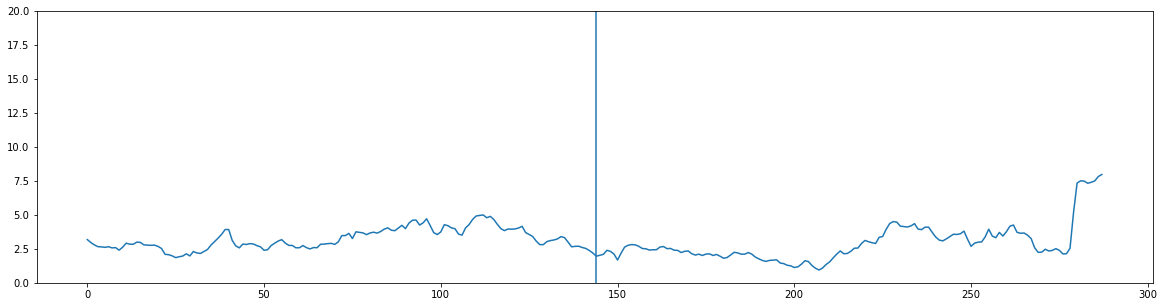

In [56]:
plt.figure(figsize=(20, 5))
plt.plot(sample_submission.loc[sample_submission["TurbID"]==1,"Wspd"])
plt.vlines(144,0,20)
plt.ylim([0,20])

(0.0, 1.0)

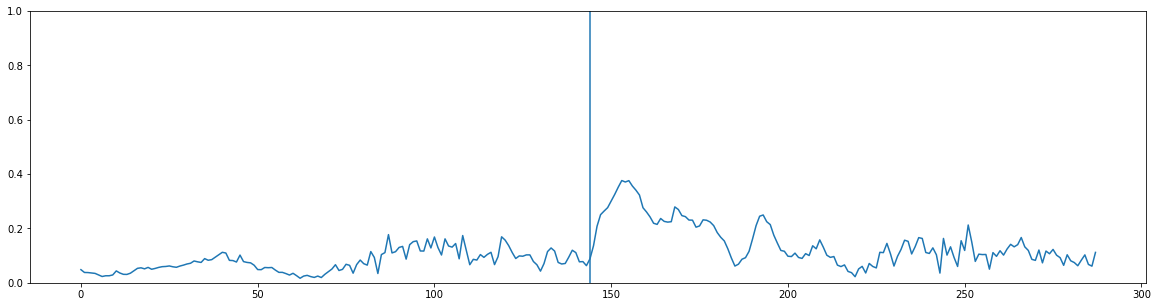

In [65]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(0,288),train_data.loc[ ((train_data["Day"]==122)|(train_data["Day"]==123)) &(train_data["TurbID"]==1) ,"Wspd"])
plt.vlines(144,0,1)
plt.ylim([0,1])